In [240]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import display

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn import svm
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectFromModel

pd.set_option("display.max_columns", 50)

np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

# Get the data

In [2]:
%run get_data.py
benchmarks = ('adpcm_encoder', 'average', 'fir')
gd = GetData('data/ES', benchmarks, load_fpga_v5=False)
gd.main()
gd.data_v4.keys()

dict_keys(['adpcm_encoder', 'average', 'fir'])

# Data analysis

In [3]:
%run methods.py

adpcm_encoder


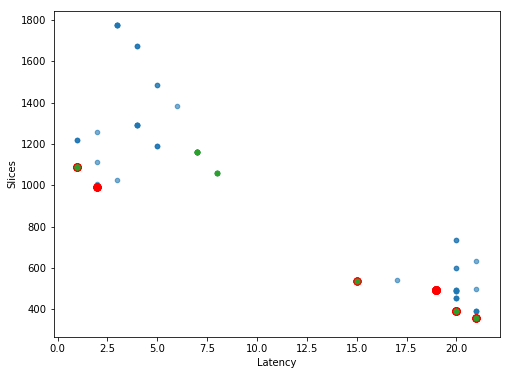

The accurate Pareto set
[[  15  536]
 [  19  493]
 [   2  992]
 [  21  356]
 [  20  392]
 [   1 1089]]
The predicted Pareto set
[[  15  536]
 [  21  356]
 [  20  392]
 [   7 1160]
 [   1 1089]
 [   8 1060]]
adrs_ave       : 0.02506897283531409
adrs_max       : 0.09778225806451613
adrs_ave_rms   : 0.026057874556347293
adrs_max_rms   : 0.08753267684958413
hypervolume    : 0.27220855398845356
dominance      : 0.6666666666666666
cardinality    : 6
average


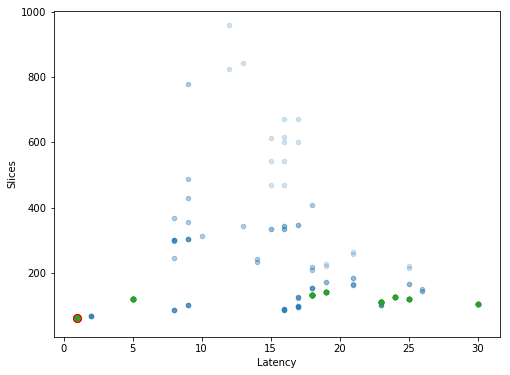

The accurate Pareto set
[[ 1 60]]
The predicted Pareto set
[[ 18 131]
 [ 24 125]
 [ 25 120]
 [ 30 104]
 [ 19 140]
 [ 23 111]
 [  1  60]
 [  5 119]]
adrs_ave       : 0.0
adrs_max       : 0.0
adrs_ave_rms   : 0.0
adrs_max_rms   : 0.0
hypervolume    : 0.4526181511763195
dominance      : 1.0
cardinality    : 8
fir


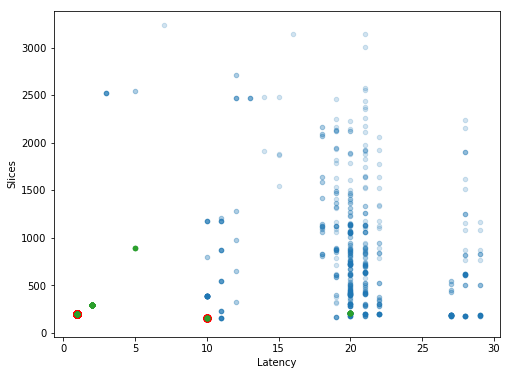

The accurate Pareto set
[[ 10 153]
 [  1 199]]
The predicted Pareto set
[[  1 199]
 [  2 296]
 [ 10 153]
 [  5 891]
 [ 20 206]]
adrs_ave       : 0.0
adrs_max       : 0.0
adrs_ave_rms   : 0.0
adrs_max_rms   : 0.0
hypervolume    : 0.3377235497291035
dominance      : 1.0
cardinality    : 5


In [4]:
results_direct_mapping = {}
for i in benchmarks:
    print(i)
    results_direct_mapping[i] = DirectMapping.main(gd.data_v4[i], plot_figure=True, display_table=True)
    print_results(results_direct_mapping[i])
    print('=' * 40)

## Method starts

In [5]:
%run machine_learning.py

In [6]:
features = ['AREA', 'state', 'FU', 'REG', 'MUX', 'DEC', 'pin_pair',
            'net', 'max', 'min', 'ave', 'MISC', 'MEM', 'sim', 'Pmax',
            'Pmin', 'Pave', 'Latency', 'BlockMemoryBit', 'DSP', 'Slices']
# 'CP_delay',

invalid_features = ['Slices', 'Latency']
valid_features = [i for i in features if i not in invalid_features]
label = 'Slices'

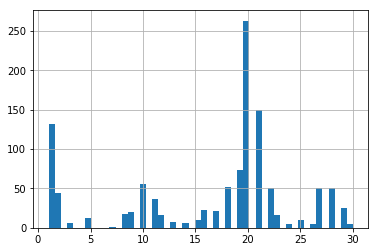

In [146]:
# combine multiple benchmarks
benchmark_train = ('fir', 'average')
# benchmark_train = ('adpcm_encoder', 'average')
data_train = pd.concat([gd.data_v4[i] for i in benchmark_train], axis=0, ignore_index=True)[features]
data_train['Latency'].hist(bins=50)
plt.show()

In [147]:
# fix missing data
data_train = ML.fix_missing_data(data_train)
display(data_train.head(2))
data_train.info()

,AREA,state,FU,REG,MUX,DEC,pin_pair,net,max,min,ave,MISC,MEM,sim,Pmax,Pmin,Pave,Latency,BlockMemoryBit,DSP,Slices
0,4704,3,1207,2772,698,0,6834,3256,3,3,3.0,27,0,0,0,0,0,19,0,0,172
1,4704,3,1207,2772,698,0,6834,3256,3,3,3.0,27,0,0,0,0,0,19,0,0,172


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162 entries, 0 to 1161
Data columns (total 21 columns):
AREA              1162 non-null int64
state             1162 non-null int64
FU                1162 non-null int64
REG               1162 non-null int64
MUX               1162 non-null int64
DEC               1162 non-null int64
pin_pair          1162 non-null int64
net               1162 non-null int64
max               1162 non-null int64
min               1162 non-null int64
ave               1162 non-null float64
MISC              1162 non-null int64
MEM               1162 non-null int64
sim               1162 non-null int64
Pmax              1162 non-null int64
Pmin              1162 non-null int64
Pave              1162 non-null int64
Latency           1162 non-null int64
BlockMemoryBit    1162 non-null int64
DSP               1162 non-null int64
Slices            1162 non-null int64
dtypes: float64(1), int64(20)
memory usage: 190.7 KB


In [148]:
# X, y
X, y = ML.separate_feature_label(data_train, invalid_features=invalid_features, label=label)

In [149]:
# feature scaling
X = ML.feature_scaling(X)
print(X.shape)
X

(1162, 19)


array([[-0.2778, -0.9541, -0.5823, ...,  0.    ,  0.    ,  0.    ],
       [-0.2778, -0.9541, -0.5823, ...,  0.    ,  0.    ,  0.    ],
       [-0.2778, -0.9541, -0.5823, ...,  0.    ,  0.    ,  0.    ],
       ..., 
       [-0.9397, -0.5084, -0.8028, ...,  0.    ,  0.    ,  0.    ],
       [-0.7168, -0.5084, -0.6064, ...,  0.    ,  0.    ,  0.    ],
       [-0.5897, -0.5084, -0.459 , ...,  0.    ,  0.    ,  0.    ]])

In [150]:
# feature importance
estimator = RandomForestRegressor()
estimator.fit(X, y)
valid_features = [i for i in features if i not in ['Slices', 'Latency']]
for i in np.argsort(estimator.feature_importances_)[::-1]:
    print('{}: {:7.3}'.format(valid_features[i], estimator.feature_importances_[i]))

MUX:   0.954
pin_pair:  0.0158
net: 0.00822
FU: 0.00811
AREA:  0.0032
REG: 0.00258
min: 0.00206
MISC: 0.00176
max: 0.00162
state:  0.0015
ave: 0.000582
DEC: 0.000328
BlockMemoryBit:     0.0
MEM:     0.0
sim:     0.0
Pmax:     0.0
Pmin:     0.0
Pave:     0.0
DSP:     0.0


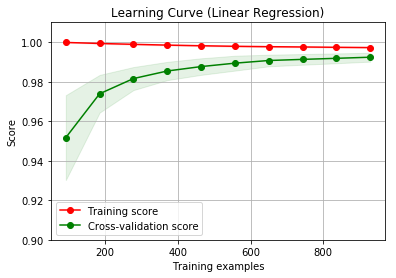

[[  92.        0.9998    0.9517]
 [ 185.        0.9993    0.9739]
 [ 278.        0.9989    0.9816]
 [ 371.        0.9985    0.9854]
 [ 464.        0.9982    0.9876]
 [ 557.        0.9979    0.9894]
 [ 650.        0.9977    0.9907]
 [ 743.        0.9976    0.9913]
 [ 836.        0.9974    0.9918]
 [ 929.        0.9973    0.9924]]
Wall time: 14 s


In [151]:
%%time
title = 'Learning Curve (Linear Regression)'
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
estimator = ensemble.GradientBoostingRegressor(random_state=42)
scores = ML.plot_learning_curve(estimator, title, X, y, ylim=(0.9, 1.01), cv=cv, n_jobs=4)
plt.show()
print(scores)

In [228]:
train_set, test_set = ML.split_data(data_train, distribution=data_train['Latency'], train_size=1100)

In [229]:
X, y = ML.separate_feature_label(train_set, invalid_features=['Slices', 'Latency'], label='Slices')
print(X.shape)
X.head(2)

(1100, 19)


,AREA,state,FU,REG,MUX,DEC,pin_pair,net,max,min,ave,MISC,MEM,sim,Pmax,Pmin,Pave,BlockMemoryBit,DSP
186,3188,13,1327,1134,670,0,5811,2724,13,13,13.0,57,0,0,0,0,0,0,0
174,2326,5,1213,714,367,0,3863,1962,5,5,5.0,32,0,0,0,0,0,0,0


In [230]:
X = ML.feature_scaling(X)

In [231]:
estimator.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=42, subsample=1.0, verbose=0,
             warm_start=False)

adpcm_encoder


,AREA,state,FU,REG,MUX,DEC,pin_pair,net,max,min,ave,MISC,MEM,sim,Pmax,Pmin,Pave,Latency,BlockMemoryBit,DSP,Slices
0,489.261821,3,670,642,501,0,3588,1621,3,3,3.0,26,0,0,0,0,0,20,0,0,456
1,498.007508,2,900,624,489,0,3905,1793,2,2,2.0,22,0,0,0,0,0,19,0,0,493


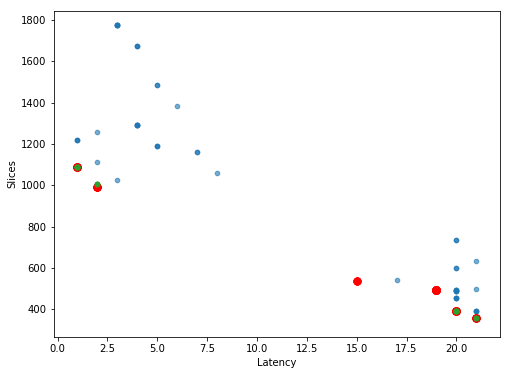

adrs_ave       : 0.06667963591775136
adrs_max       : 0.3333333333333333
adrs_ave_rms   : 0.08125875038442938
adrs_max_rms   : 0.2687134155004866
hypervolume    : 0.9802921779090491
dominance      : 0.5
cardinality    : 4

adrs_ave       : 0.02506897283531409
adrs_max       : 0.09778225806451613
adrs_ave_rms   : 0.026057874556347293
adrs_max_rms   : 0.08753267684958413
hypervolume    : 0.27220855398845356
dominance      : 0.6666666666666666
cardinality    : 6


In [232]:
benchmark_test = [i for i in benchmarks if i not in benchmark_train]
for i in benchmark_test:
    data_test = ML.fix_missing_data(gd.data_v4[i][features])
    X, y = ML.separate_feature_label(data_test, valid_features=valid_features, label=label)
    X = ML.feature_scaling(X)
    y_pred = estimator.predict(X)
    data_test['AREA'] = y_pred
    print(i)
    display(data_test.head(2))
    print_results(DirectMapping.main(data_test, plot_figure=True))
    print()
    print_results(results_direct_mapping[i])

## Use regularization

In [86]:
%%time
alphas = np.arange(0.1, 10.1, 0.1)
scores_train = []
scores_test = []
X, y = ML.separate_feature_label(data_train, invalid_features=['Slices', 'Latency'], label='Slices')
X = ML.feature_scaling(X)
for alpha in alphas:
#     estimator = linear_model.Lasso(alpha=alpha)
#     estimator = linear_model.ElasticNet(alpha=alpha)
    estimator = linear_model.Ridge(alpha=alpha)
    scores_cv_train, scores_cv_test = [], []
    # cross-validation using shuffle split
    for train_indices, test_indices in ShuffleSplit(n_splits=5, random_state=42).split(X):
        estimator.fit(X[train_indices], y[train_indices])
        scores_cv_train.append(estimator.score(X[train_indices], y[train_indices]))
        scores_cv_test.append(estimator.score(X[test_indices], y[test_indices]))
    scores_train.append(np.mean(scores_cv_train))
    scores_test.append(np.mean(scores_cv_test))

Wall time: 4.43 s


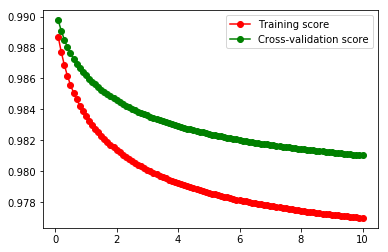

In [87]:
plt.plot(alphas, scores_train, 'o-', color='r', label='Training score')
plt.plot(alphas, scores_test, 'o-', color='g', label='Cross-validation score')
plt.legend(loc='best')
plt.show()

In [100]:
np.sort(cross_val_score(linear_model.BayesianRidge(), X, y, cv=ShuffleSplit(n_splits=10, random_state=42)))

array([ 0.9883,  0.9886,  0.9887,  0.989 ,  0.9893,  0.9898,  0.99  ,
        0.9901,  0.9912,  0.993 ])

## Model analysis

Perform cross-validation on the estimators using all the benchmarks to find the best estimator for the prediction problem.

In [257]:
estimators = (
    linear_model.LinearRegression(),
    linear_model.Lasso(),
    linear_model.ElasticNet(),
    Ridge(),
    svm.LinearSVR(random_state=42),
    svm.SVR(kernel='linear'),
    tree.DecisionTreeRegressor(random_state=42),
    ensemble.RandomForestRegressor(random_state=42),
    ensemble.AdaBoostRegressor(random_state=42),
    ensemble.GradientBoostingRegressor(random_state=42),
)

In [252]:
%%time
scores_cv = dict()
for estimator in estimators:
    scores = list()
    for benchmark in benchmarks:
        score_cv = cross_val_score(estimator, X, y, cv=ShuffleSplit(n_splits=10, random_state=42))
        scores.append(np.mean(score_cv))
    scores_cv[estimator.__class__] = (np.mean(scores), np.std(scores))

Wall time: 6.91 s


In [253]:
scores_cv

{sklearn.linear_model.base.LinearRegression: (0.98669240032070638,
  1.1102230246251565e-16),
 sklearn.linear_model.coordinate_descent.Lasso: (0.98350659941530927,
  1.1102230246251565e-16),
 sklearn.linear_model.coordinate_descent.ElasticNet: (0.89315852231904369,
  0.0),
 sklearn.linear_model.ridge.Ridge: (0.98544795585175449, 0.0),
 sklearn.svm.classes.LinearSVR: (0.82456122011471178, 0.0),
 sklearn.svm.classes.SVR: (0.94386758282639394, 0.0),
 sklearn.tree.tree.DecisionTreeRegressor: (0.99206820134258911,
  1.1102230246251565e-16),
 sklearn.ensemble.forest.RandomForestRegressor: (0.99379051739002777, 0.0),
 sklearn.ensemble.weight_boosting.AdaBoostRegressor: (0.96725236787537872,
  0.0),
 sklearn.ensemble.gradient_boosting.GradientBoostingRegressor: (0.99333246124558838,
  0.0)}

## Feature selection

In [261]:
%%time
for estimator in estimators:
# estimator = ensemble.GradientBoostingRegressor(random_state=42)
    print(estimator.__class__)
    selector = RFECV(estimator, step=1, cv=10)
    for i in benchmarks:
        data = ML.fix_missing_data(gd.data_v4[i][features])
        X, y = ML.separate_feature_label(data, invalid_features=invalid_features, label=label)
        X = ML.feature_scaling(X)
        selector = selector.fit(X, y)
        print(i)
        print(np.array(valid_features)[selector.support_])
        print()

<class 'sklearn.linear_model.base.LinearRegression'>
adpcm_encoder
['AREA' 'pin_pair' 'net' 'MISC']

average
['AREA' 'FU' 'REG' 'MUX' 'pin_pair' 'net' 'min' 'MISC']

fir
['AREA' 'state' 'FU' 'REG' 'MUX' 'DEC' 'pin_pair' 'net' 'max' 'min' 'ave'
 'MISC' 'MEM' 'sim' 'Pmax' 'Pmin' 'Pave' 'BlockMemoryBit' 'DSP']

<class 'sklearn.linear_model.coordinate_descent.Lasso'>
adpcm_encoder
['AREA' 'state' 'REG' 'MISC']

average
['FU' 'REG' 'MUX' 'DEC' 'MISC']

fir
['REG' 'MUX' 'net' 'max']

<class 'sklearn.linear_model.coordinate_descent.ElasticNet'>
adpcm_encoder
['AREA' 'FU' 'REG' 'MUX' 'pin_pair' 'net' 'MISC']

average
['AREA' 'MUX' 'DEC' 'pin_pair' 'net' 'ave' 'MISC']

fir
['MUX' 'pin_pair']

<class 'sklearn.linear_model.ridge.Ridge'>
adpcm_encoder
['AREA' 'state' 'FU' 'REG' 'pin_pair' 'net' 'min' 'ave' 'MISC']

average
['AREA' 'state' 'REG' 'MUX' 'DEC' 'pin_pair' 'net' 'max' 'min' 'ave' 'MISC']

fir
['AREA' 'state' 'FU' 'REG' 'MUX' 'DEC' 'pin_pair' 'net' 'max' 'min' 'ave'
 'MISC']

<class 'skl